In [1]:
from hossam import *
from pandas import DataFrame, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

from scipy.spatial import ConvexHull

from 성능평가함수 import *

import shap

In [2]:
origin=load_data('pima_indians_diabetes_preprocessed')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

===== 데이터 크기 확인 =====
데이터셋 크기 : (768, 9)
행 개수 : 768개
열 개수 : 9개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 54.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


In [3]:
df=origin.copy()

df['Outcome']=df['Outcome'].astype('int')

yname='Outcome'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=52)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [4]:
%%time

pipe=Pipeline([
    ('VIF_Selector', VIFSelector()),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=52))
])

param_grid={
    'model__penalty':['l2'],
    'model__solver':['lbfgs'],
    'model__C':[0.01, 0.1, 1, 10, 100],
    'model__max_iter':[100, 300, 500],
    'model__class_weight':[None, 'balanced']
}

gs=GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

gs.fit(x_train, y_train)

estimator=gs.best_estimator_
estimator

CPU times: total: 234 ms
Wall time: 5.56 s


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=52))])

In [5]:
model=estimator.named_steps['model']

x_vif=estimator.named_steps['VIF_Selector'].transform(x_train)
x_scaled=estimator.named_steps['scaler'].transform(x_vif)

masker=shap.maskers.Independent(x_scaled)

explainer=shap.LinearExplainer(model, masker=masker)

shap_values=explainer.shap_values(x_scaled)
shap_values

array([[ 0.36637001,  1.19352029, -0.02374752, ...,  0.13558711,
         0.0109997 ,  0.3214378 ],
       [ 0.49955471, -0.66502013,  0.00984162, ...,  1.34818579,
        -0.39504107,  0.25401179],
       [ 0.36637001,  0.19161826, -0.01702969, ..., -0.27607911,
         0.26673056,  0.46305622],
       ...,
       [ 0.0942495 , -0.19673964,  0.01991836, ..., -1.18774282,
        -0.0015263 ,  0.13042584],
       [-0.00905658, -1.44309066,  0.03671293, ..., -1.20308754,
         0.01213369, -0.41599405],
       [ 0.25002199, -0.8945048 ,  0.04343076, ...,  0.2996527 ,
        -0.00381409,  0.2769961 ]])

In [6]:
shap_df=DataFrame(shap_values, columns=x_vif.columns, index=x_vif.index)

summary_df=DataFrame({
    'feature':shap_df.columns,
    'mean_abs_shap':shap_df.abs().mean().values,
    'mean_shap':shap_df.mean().values,
    'std_shap':shap_df.std().values
})

summary_df['direction']=np.where(
    summary_df['mean_shap']>0,
    '양(+)의 경향',
    np.where(summary_df['mean_shap']<0, '음(-)의 경향', '혼합/미약')
)

summary_df['cv']=summary_df['std_shap']/(summary_df['mean_abs_shap']+1e-9)
summary_df['variability']=np.where(summary_df['cv']<1, 'stable', 'variable')

summary_df=summary_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

total_importance=summary_df['mean_abs_shap'].sum()
summary_df['importance_ratio']=summary_df['mean_abs_shap']/total_importance
summary_df['importance_cumsum']=summary_df['importance_ratio'].cumsum()

summary_df['is_important']=np.where(summary_df['importance_cumsum']<=0.80, 'core', 'secondary')

summary_df

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,Glucose,0.918,-0.039,1.131,음(-)의 경향,1.232,variable,0.388,0.388,core
1,BMI,0.572,0.053,0.708,양(+)의 경향,1.236,variable,0.242,0.630,core
2,Pregnancies,0.301,-0.048,0.356,음(-)의 경향,1.182,variable,0.127,0.757,core
3,Age,0.277,-0.027,0.318,음(-)의 경향,1.150,variable,0.117,0.874,secondary
4,DiabetesPedigreeFunction,0.254,0.014,0.318,양(+)의 경향,1.249,variable,0.108,0.982,secondary
5,BloodPressure,0.031,-0.005,0.040,음(-)의 경향,1.298,variable,0.013,0.995,secondary
6,Insulin,0.009,-0.001,0.016,음(-)의 경향,1.657,variable,0.004,0.999,secondary
7,SkinThickness,0.003,-0.000,0.004,음(-)의 경향,1.409,variable,0.001,1.000,secondary


In [7]:
x=DataFrame(x_scaled, columns=x_vif.columns, index=x_vif.index)
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
754,1.165,1.091,0.464,0.452,0.007,0.117,-0.010,1.096
558,1.540,-0.554,-0.373,1.144,0.007,1.832,-1.289,0.884
584,1.165,0.205,0.297,-0.432,3.161,-0.465,0.795,1.541
78,-1.696,0.429,-0.038,0.149,0.007,1.507,-0.668,-0.580
193,1.540,0.552,-0.038,0.149,0.007,2.435,0.451,0.734
...,...,...,...,...,...,...,...,...
503,1.012,-0.927,-0.707,-0.307,-0.910,0.249,0.948,0.810
86,1.740,-0.436,-0.038,2.080,0.007,0.705,-1.056,1.096
151,0.400,-0.139,-0.624,0.149,0.007,-1.754,-0.050,0.495
525,0.109,-1.242,-1.042,-1.306,0.007,-1.776,-0.007,-1.224


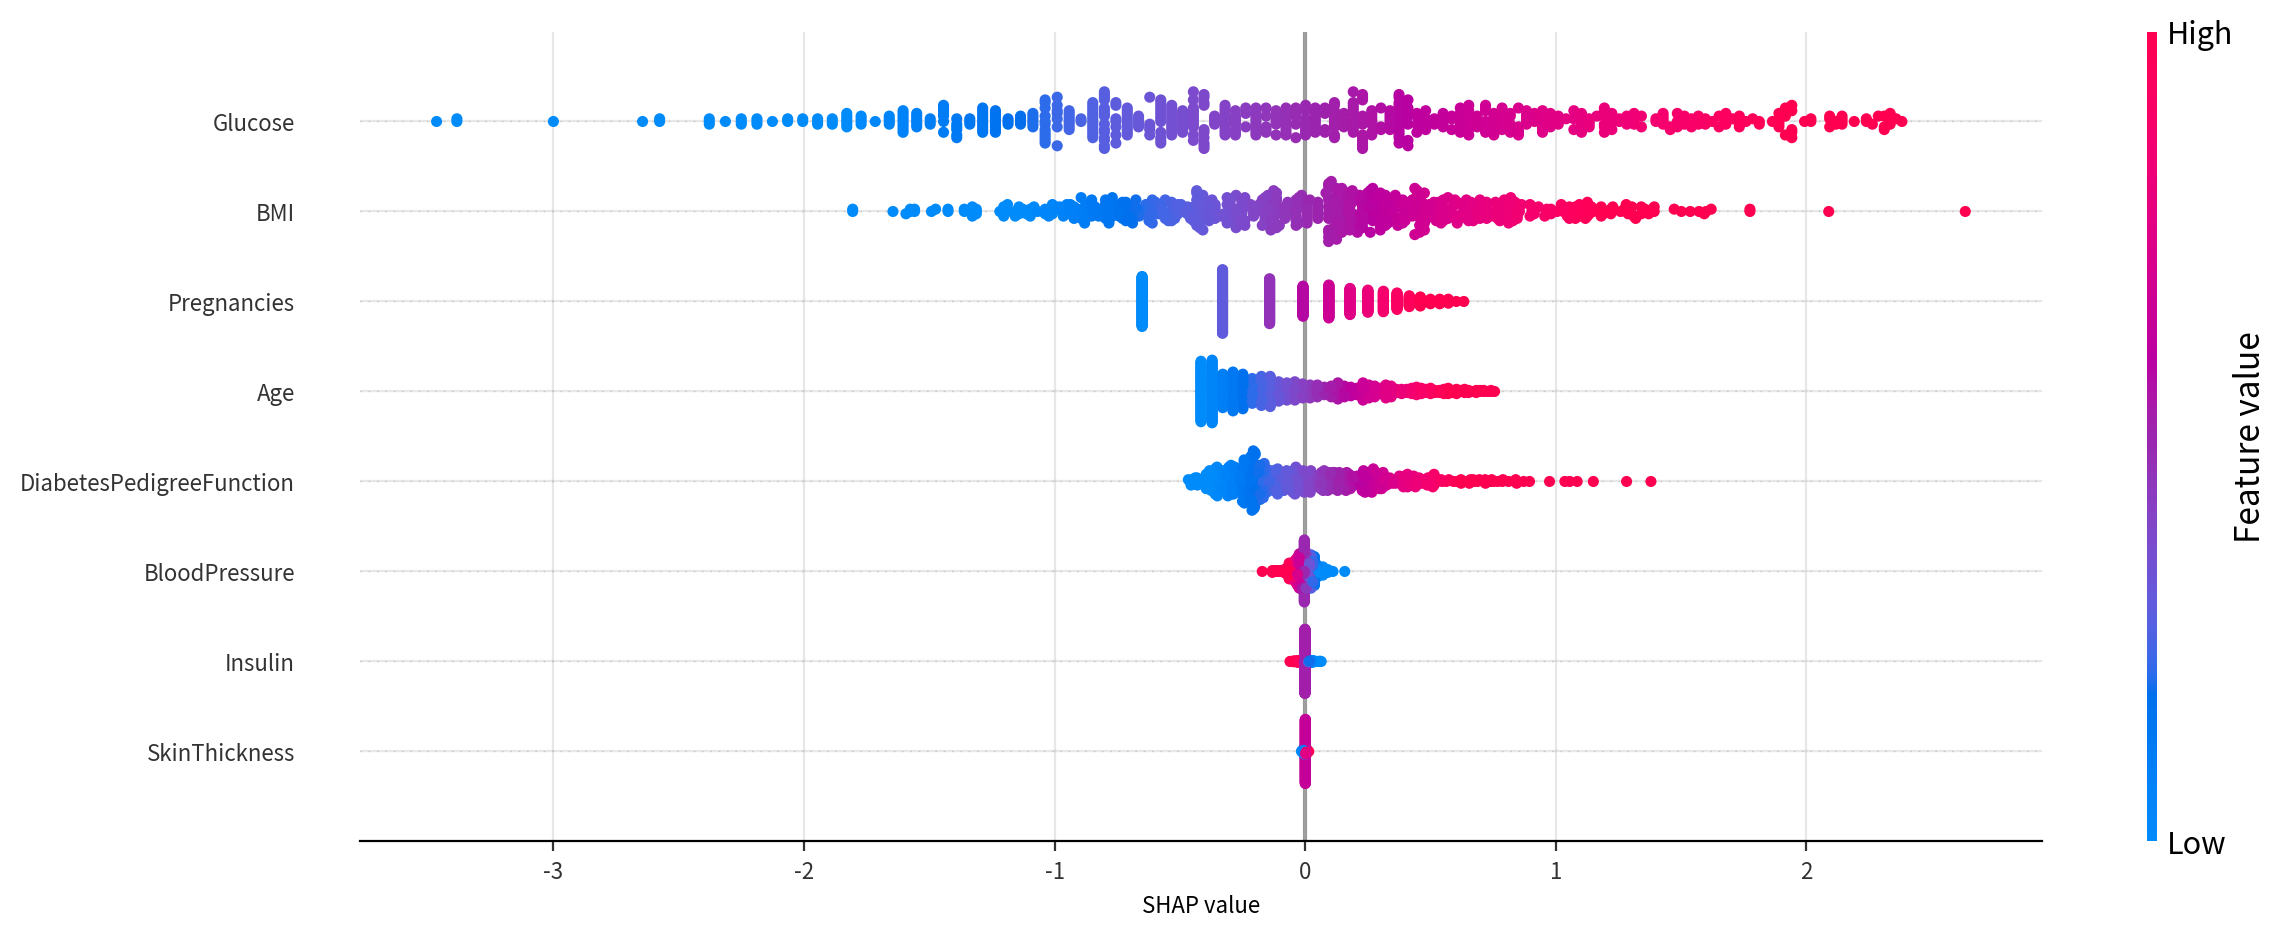

In [8]:
width=1600
my_dpi=200

shap.summary_plot(shap_values, x, show=False)

fig=plt.gcf()
fig.set_size_inches(width/100, len(summary_df)*60/100)
fig.set_dpi(my_dpi)
ax=fig.get_axes()[0]

ax.grid(True, alpha=0.3)

plt.xlabel('SHAP value', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()
plt.close()

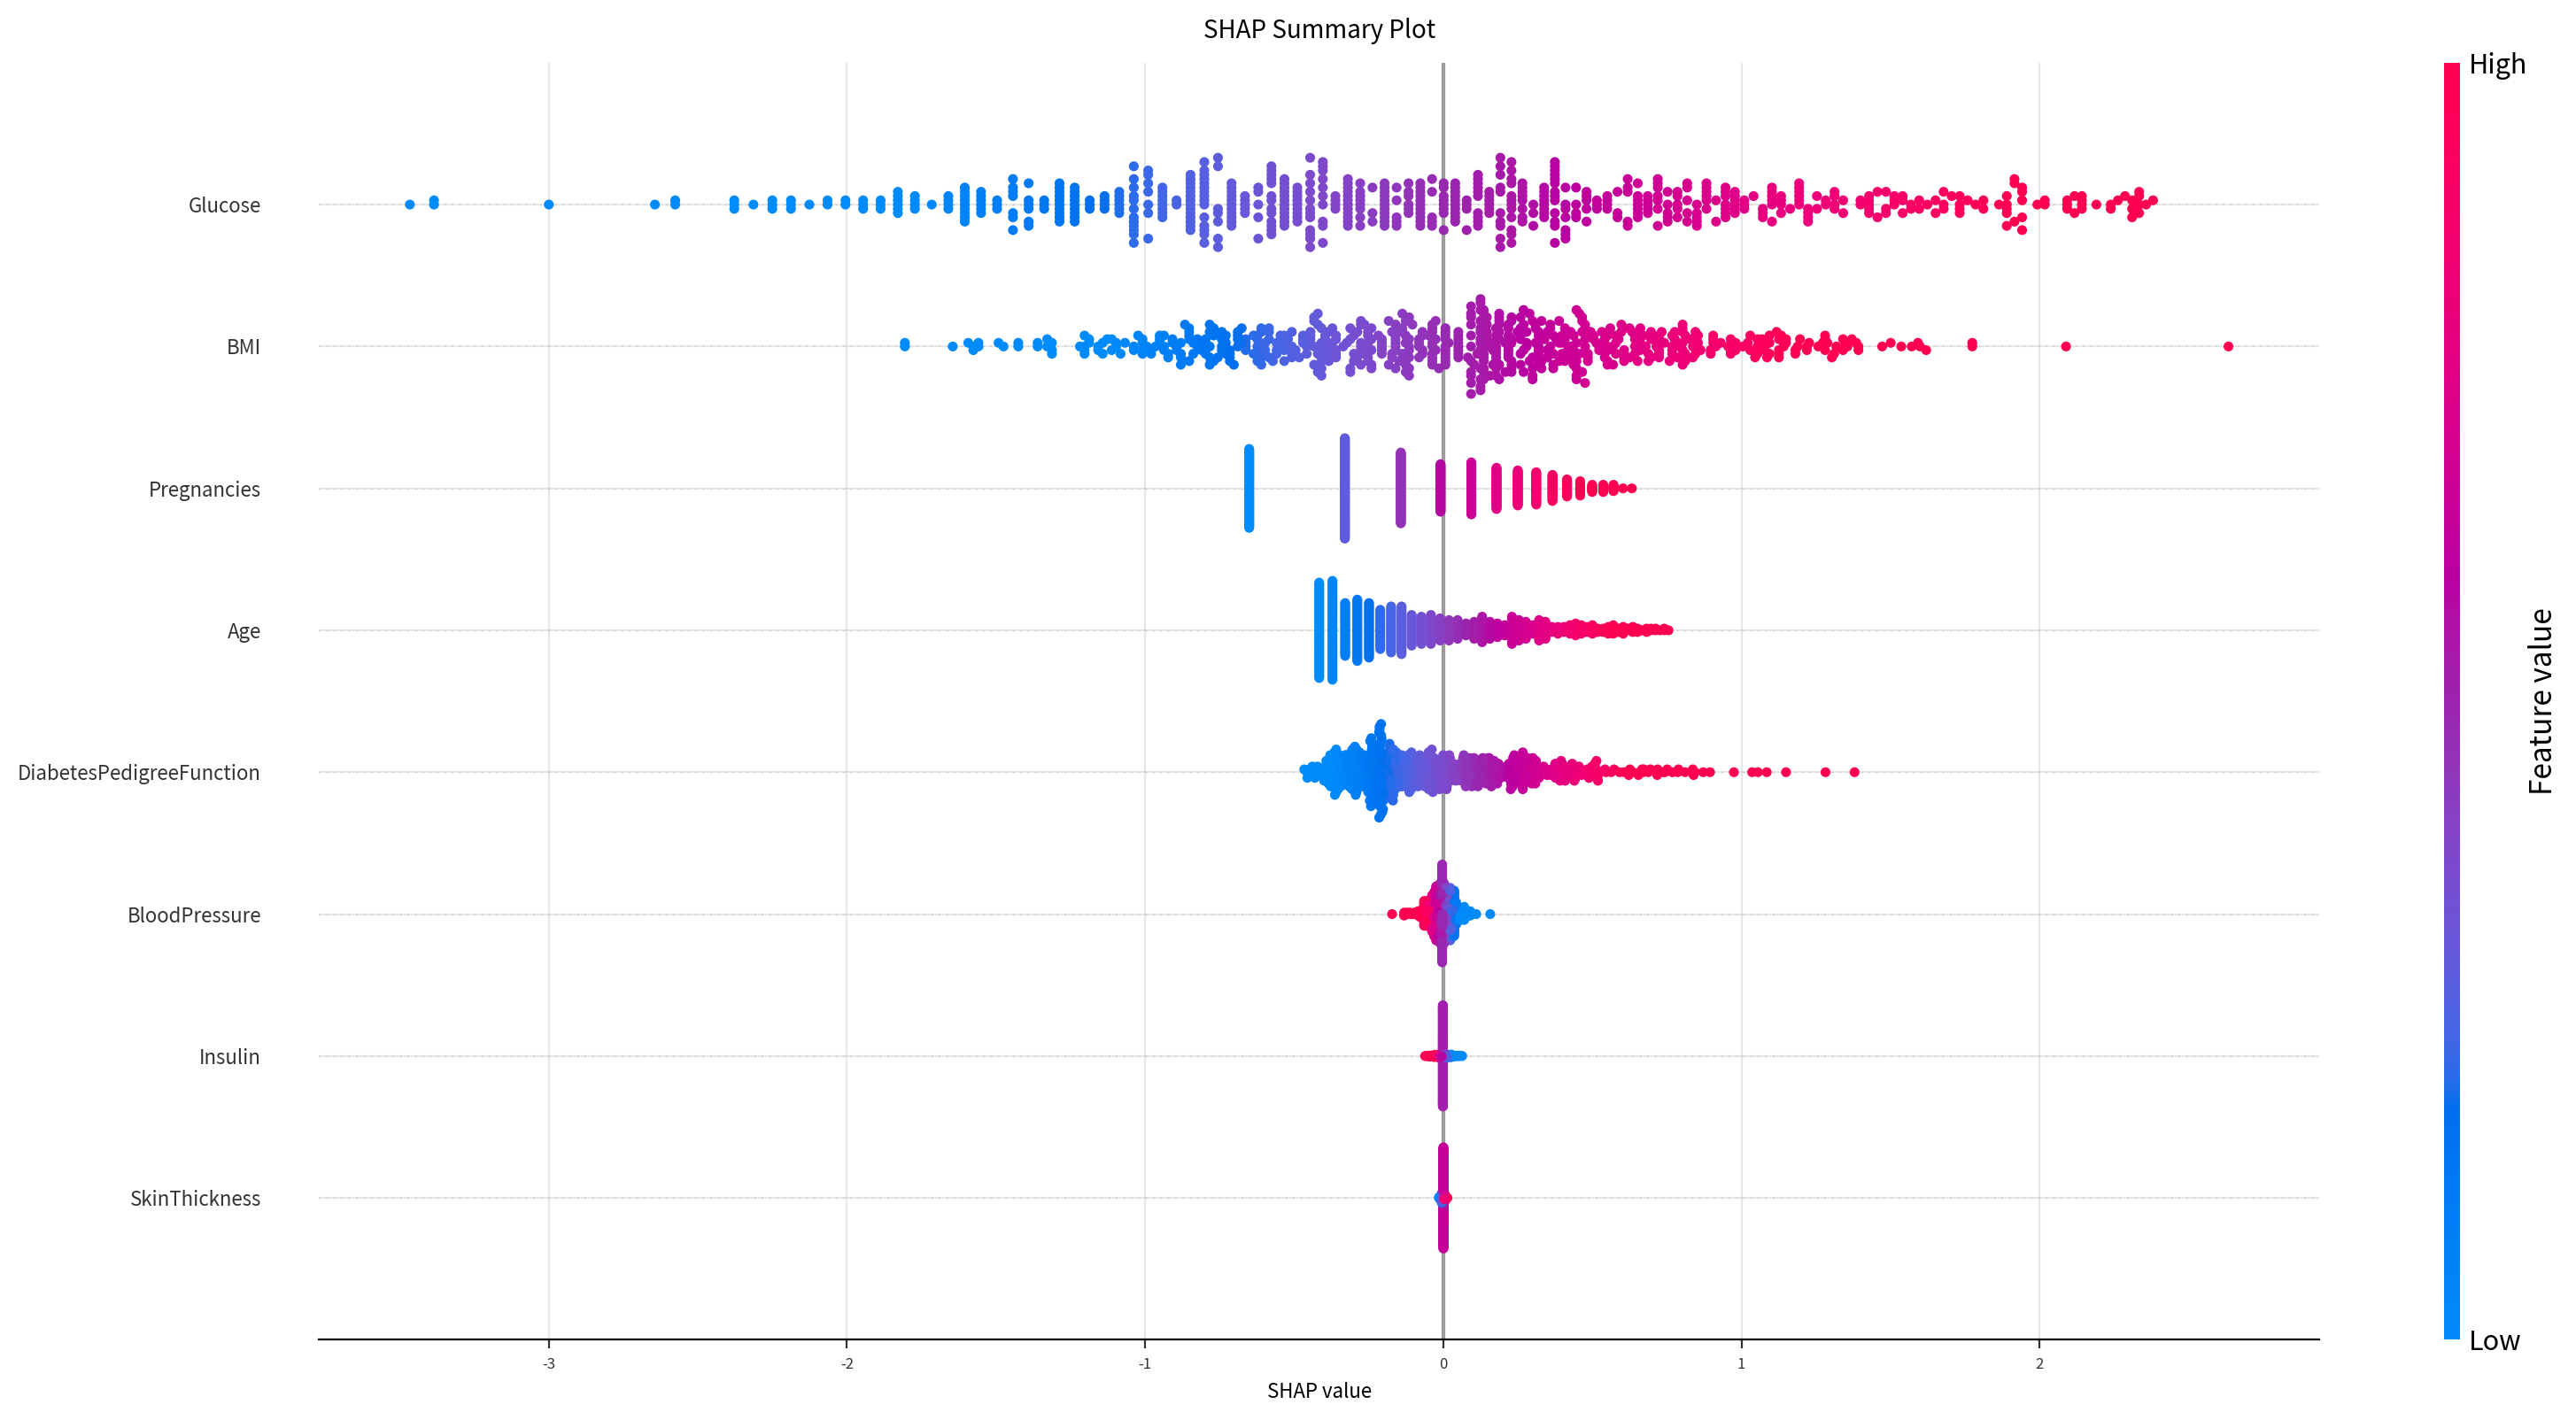

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,Glucose,0.918,-0.039,1.131,음(-) 경향,1.232,variable,0.388,0.388,core
1,BMI,0.572,0.053,0.708,양(+) 경향,1.236,variable,0.242,0.630,core
2,Pregnancies,0.301,-0.048,0.356,음(-) 경향,1.182,variable,0.127,0.757,core
3,Age,0.277,-0.027,0.318,음(-) 경향,1.150,variable,0.117,0.874,secondary
4,DiabetesPedigreeFunction,0.254,0.014,0.318,양(+) 경향,1.249,variable,0.108,0.982,secondary
5,BloodPressure,0.031,-0.005,0.040,음(-) 경향,1.298,variable,0.013,0.995,secondary
6,Insulin,0.009,-0.001,0.016,음(-) 경향,1.657,variable,0.004,0.999,secondary
7,SkinThickness,0.003,-0.000,0.004,음(-) 경향,1.409,variable,0.001,1.000,secondary


array([[ 3.66370005e-01,  1.19352029e+00, -2.37475226e-02,
         1.59167714e-03, -1.06402253e-03,  1.35587113e-01,
         1.09996996e-02,  3.21437797e-01],
       [ 4.99554705e-01, -6.65020126e-01,  9.84161828e-03,
         4.03414454e-03, -1.06402253e-03,  1.34818579e+00,
        -3.95041073e-01,  2.54011794e-01],
       [ 3.66370005e-01,  1.91618259e-01, -1.70296944e-02,
        -1.53230882e-03, -5.00752532e-02, -2.76079114e-01,
         2.66730565e-01,  4.63056225e-01],
       [-6.50852563e-01,  4.45402245e-01, -3.59403808e-03,
         5.19221708e-04, -1.06402253e-03,  1.11793270e+00,
        -1.98046170e-01, -2.11246035e-01],
       [ 4.99554705e-01,  5.84445304e-01, -3.59403808e-03,
         5.19221708e-04, -1.06402253e-03,  1.77434545e+00,
         1.57395283e-01,  2.06394534e-01]])

In [9]:
summary_df, shap_values=hs_shap_analysis(estimator, x_train)
display(summary_df)
display(shap_values[:5])

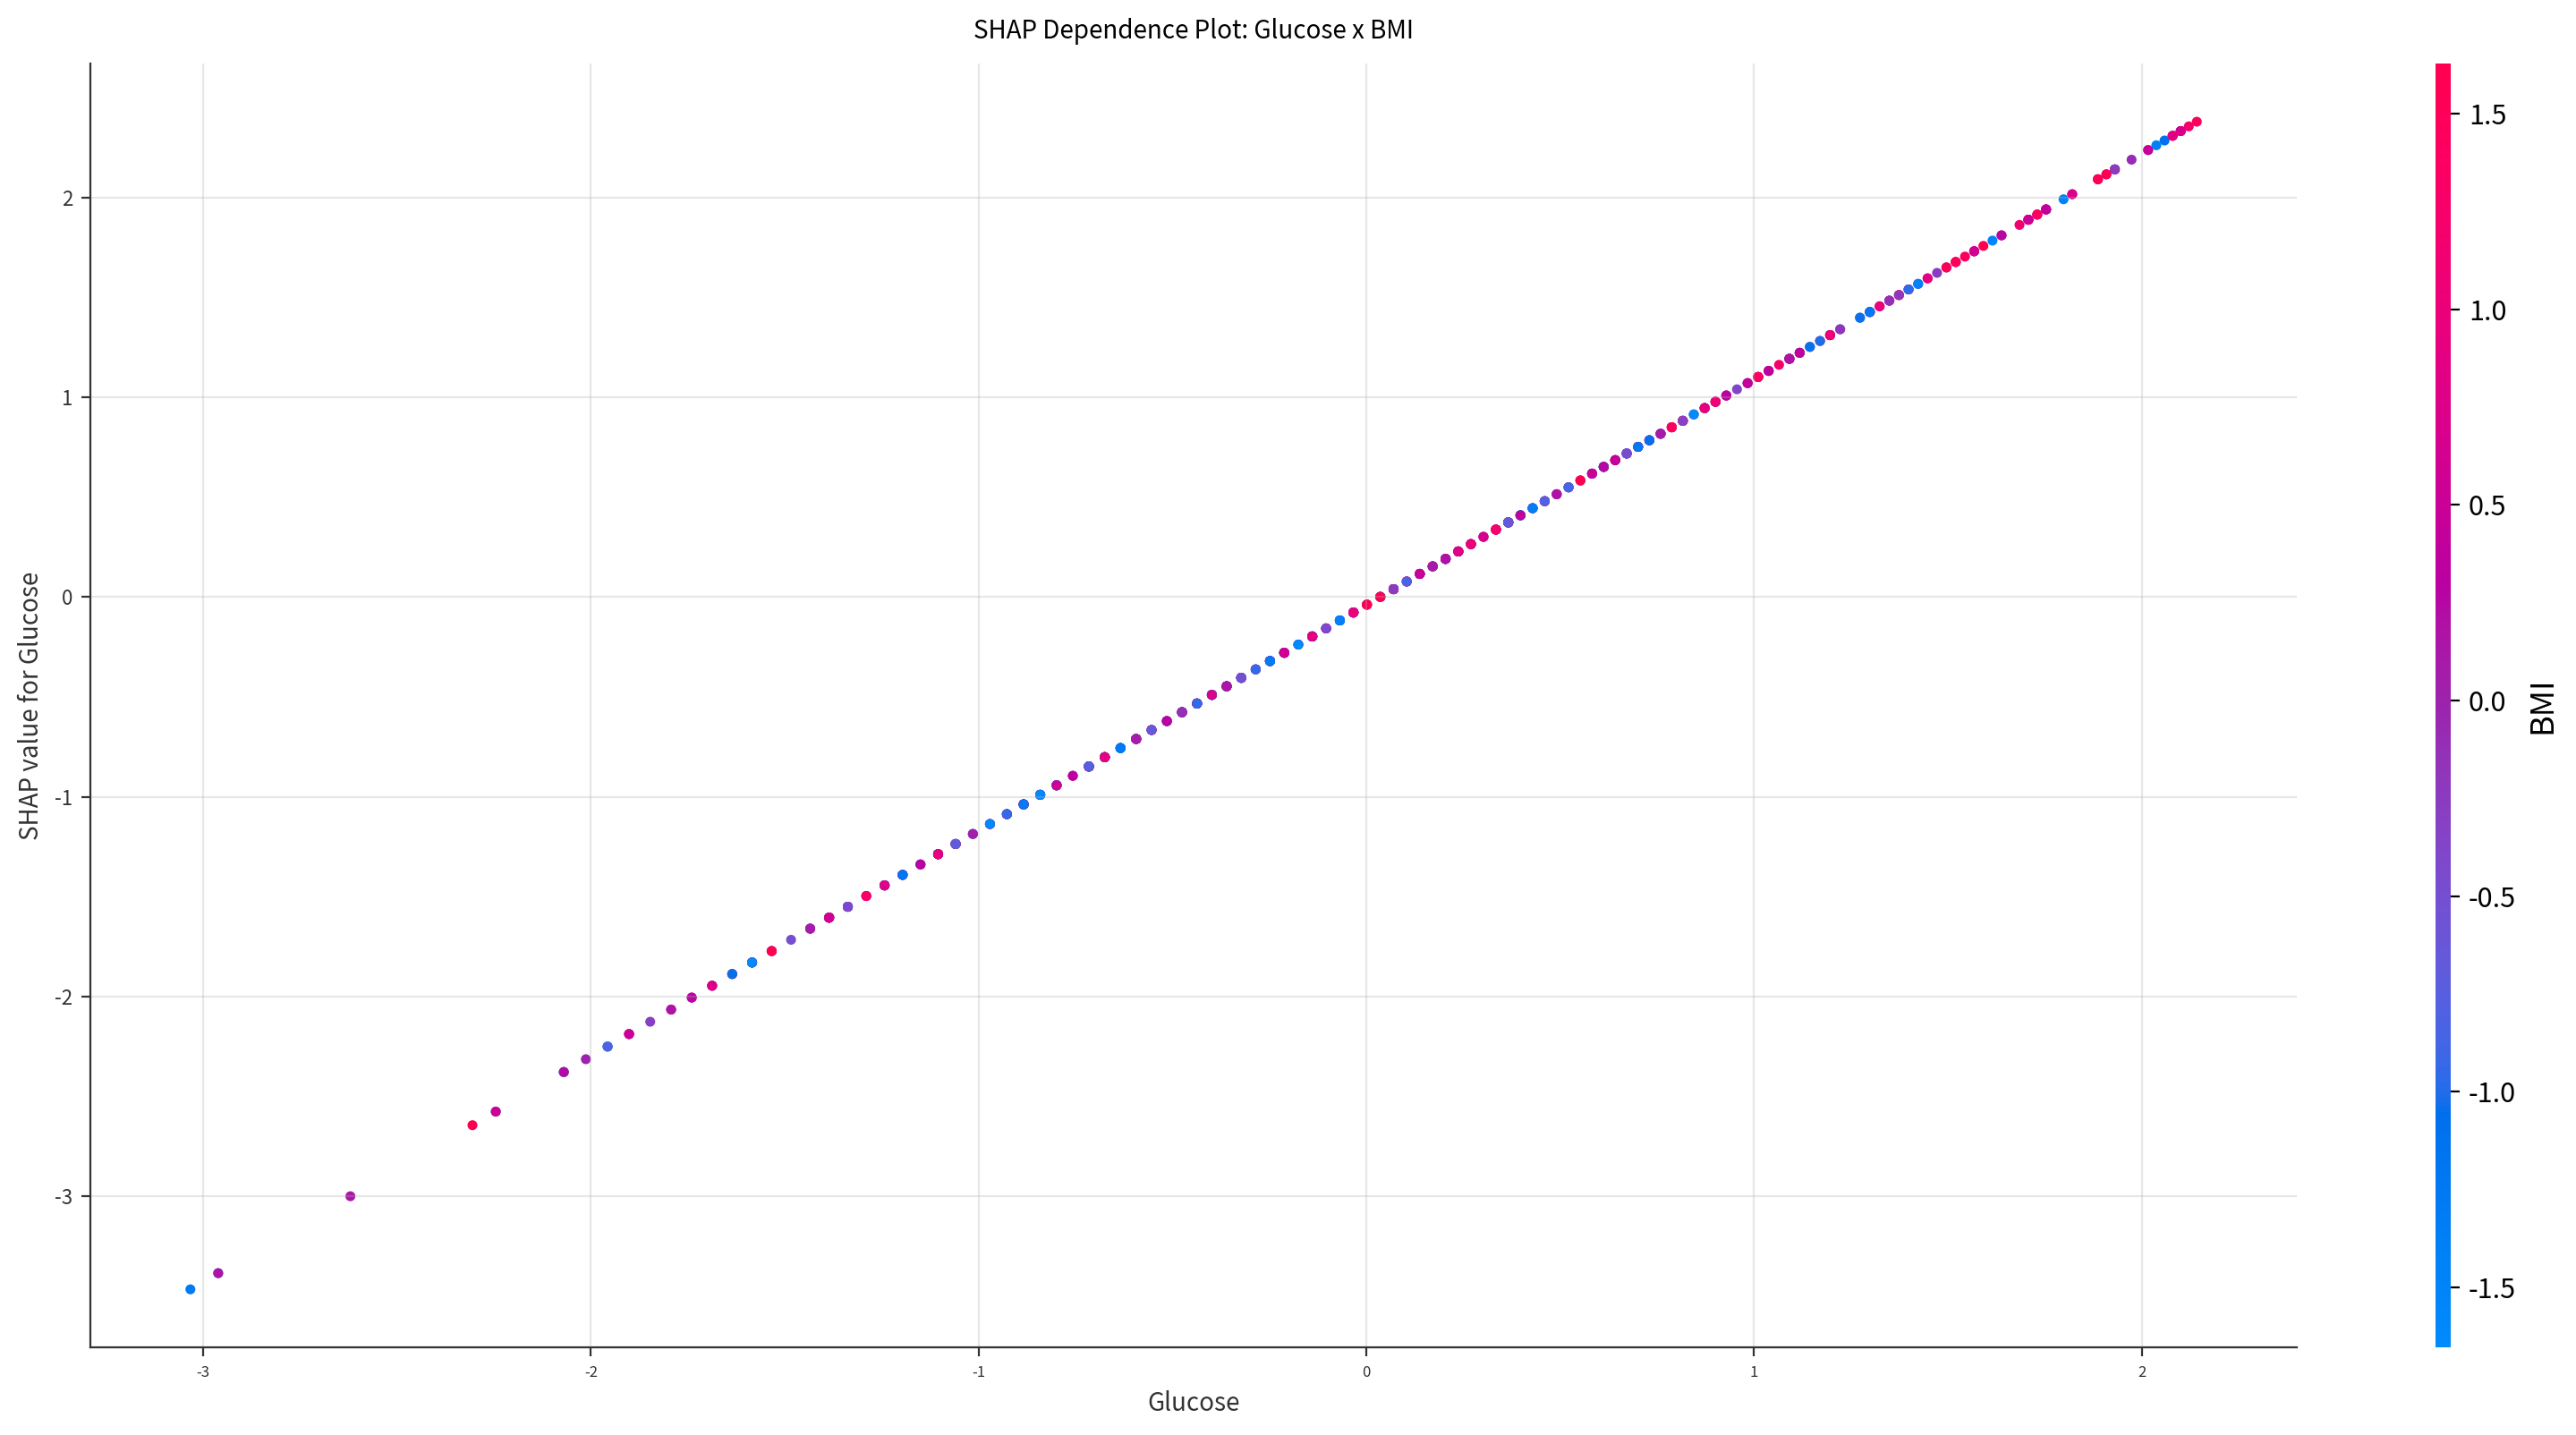

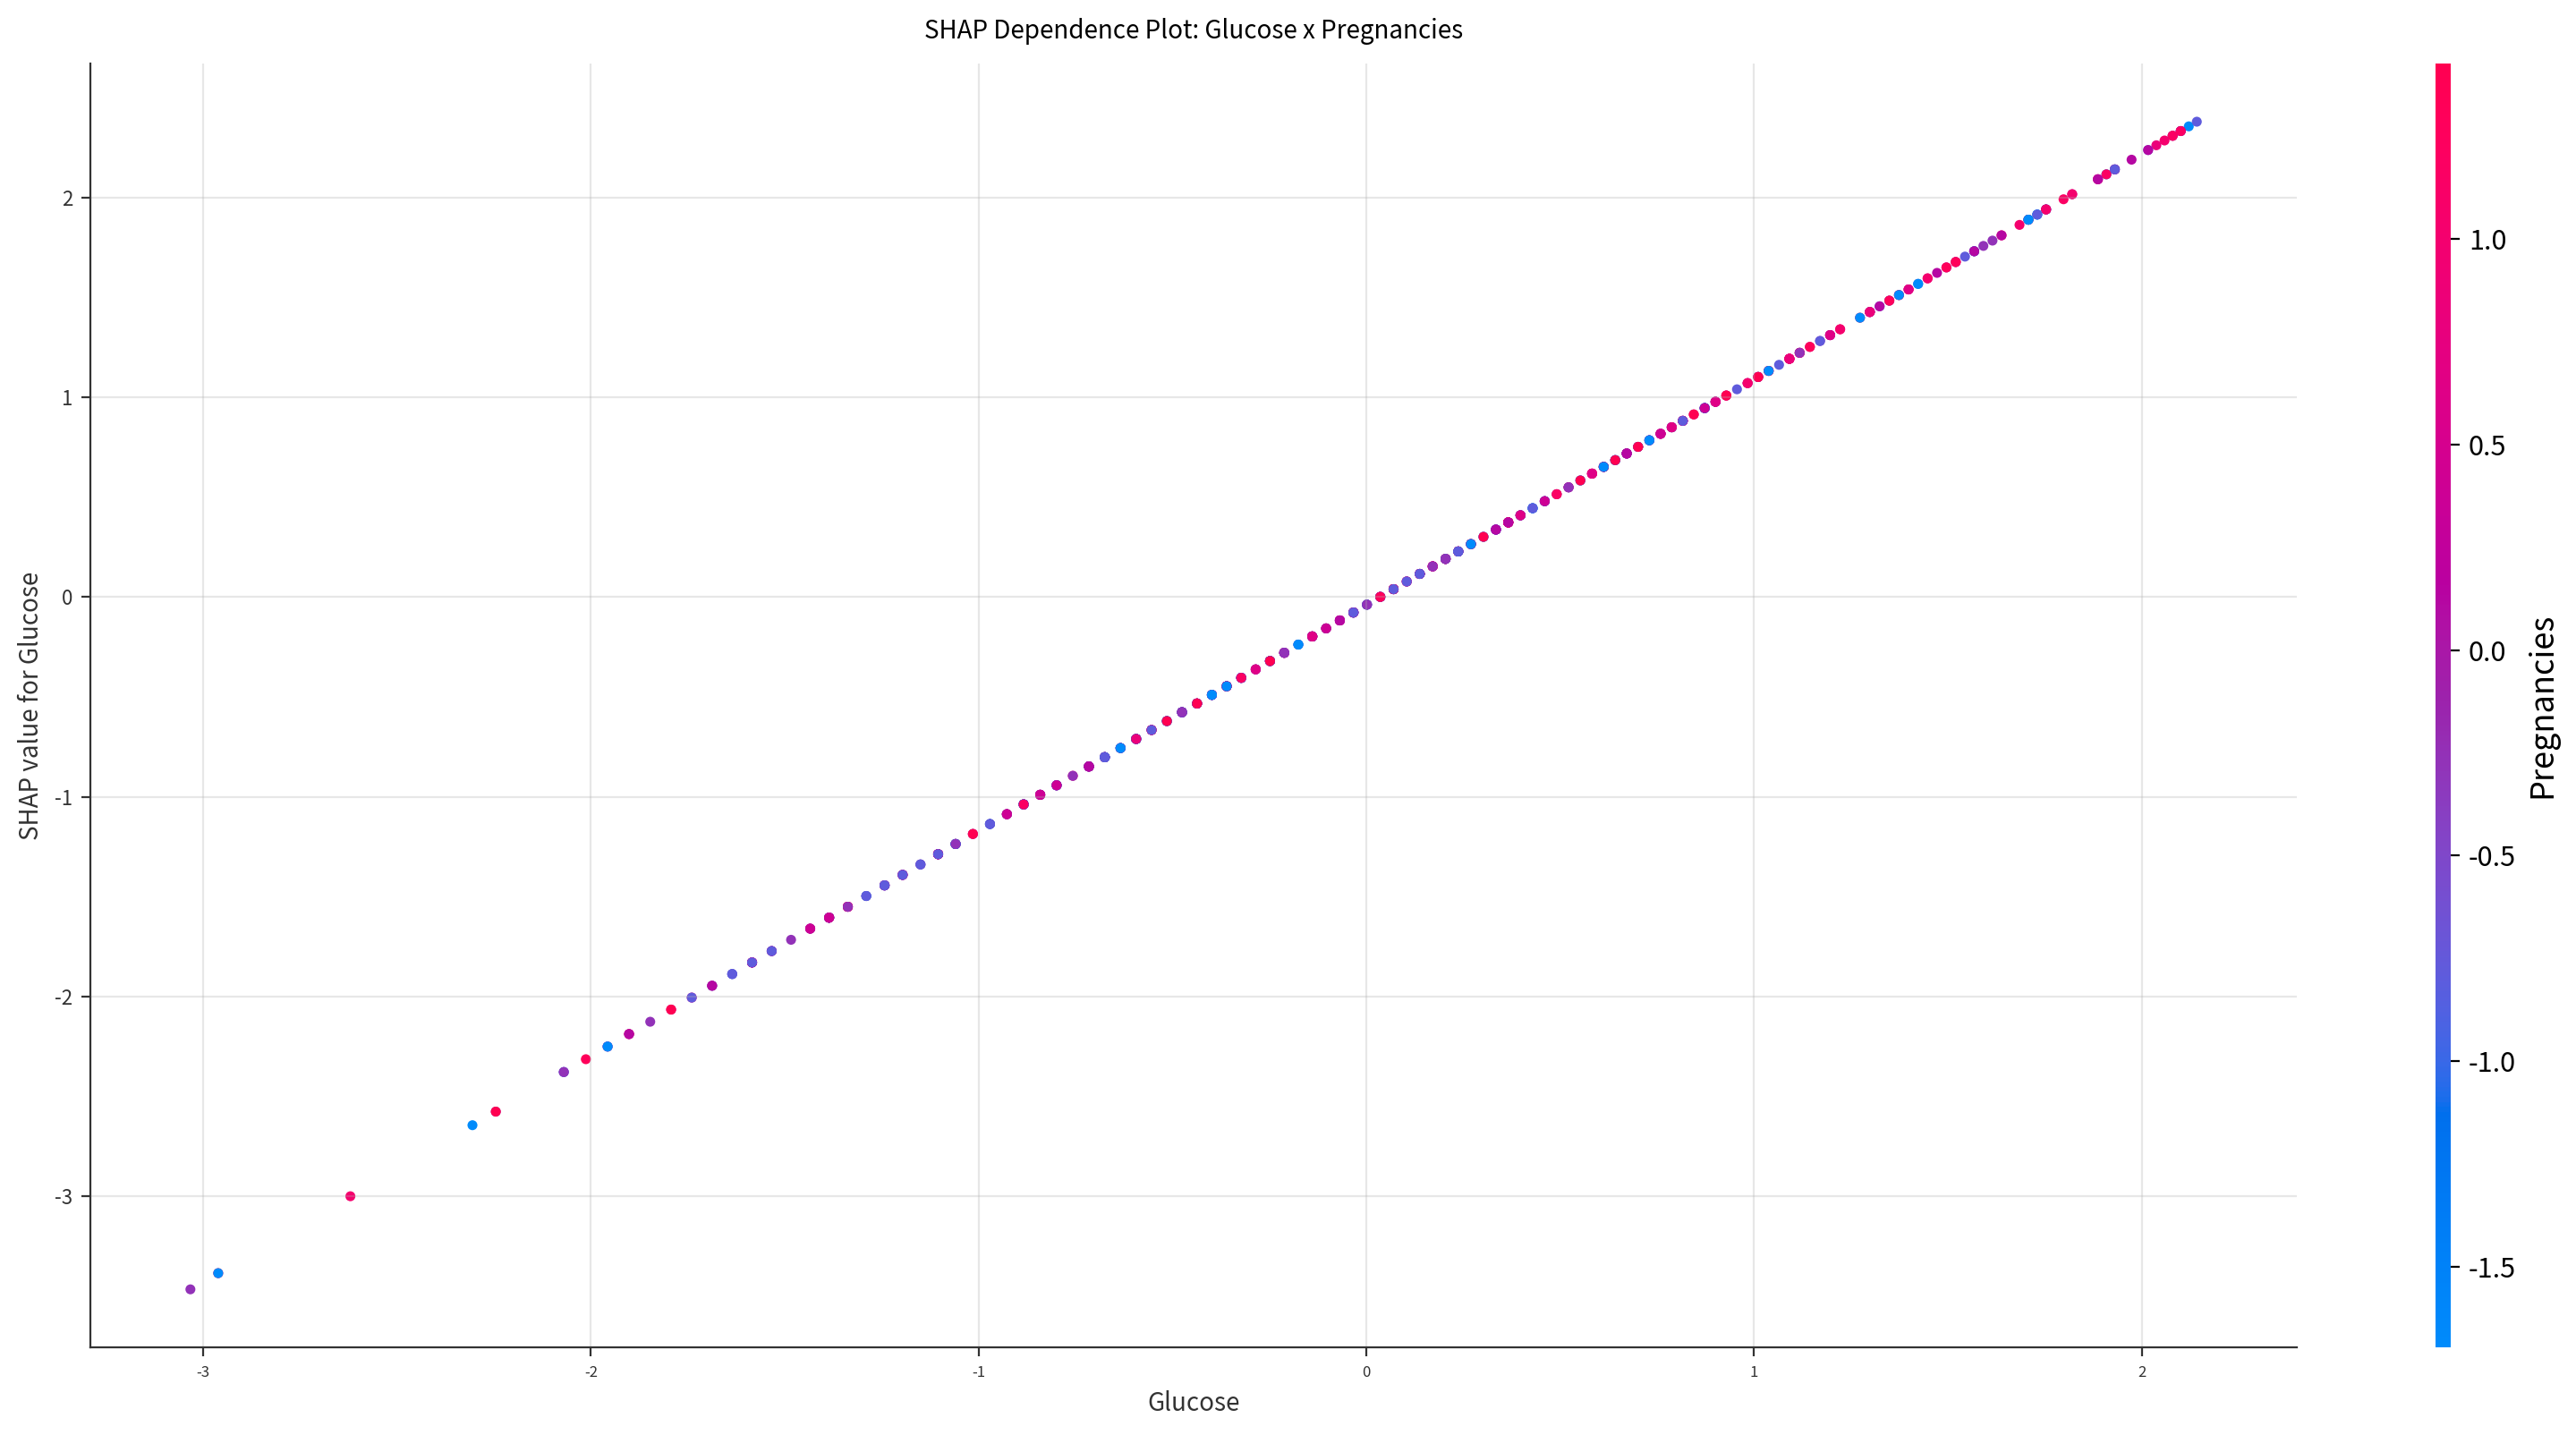

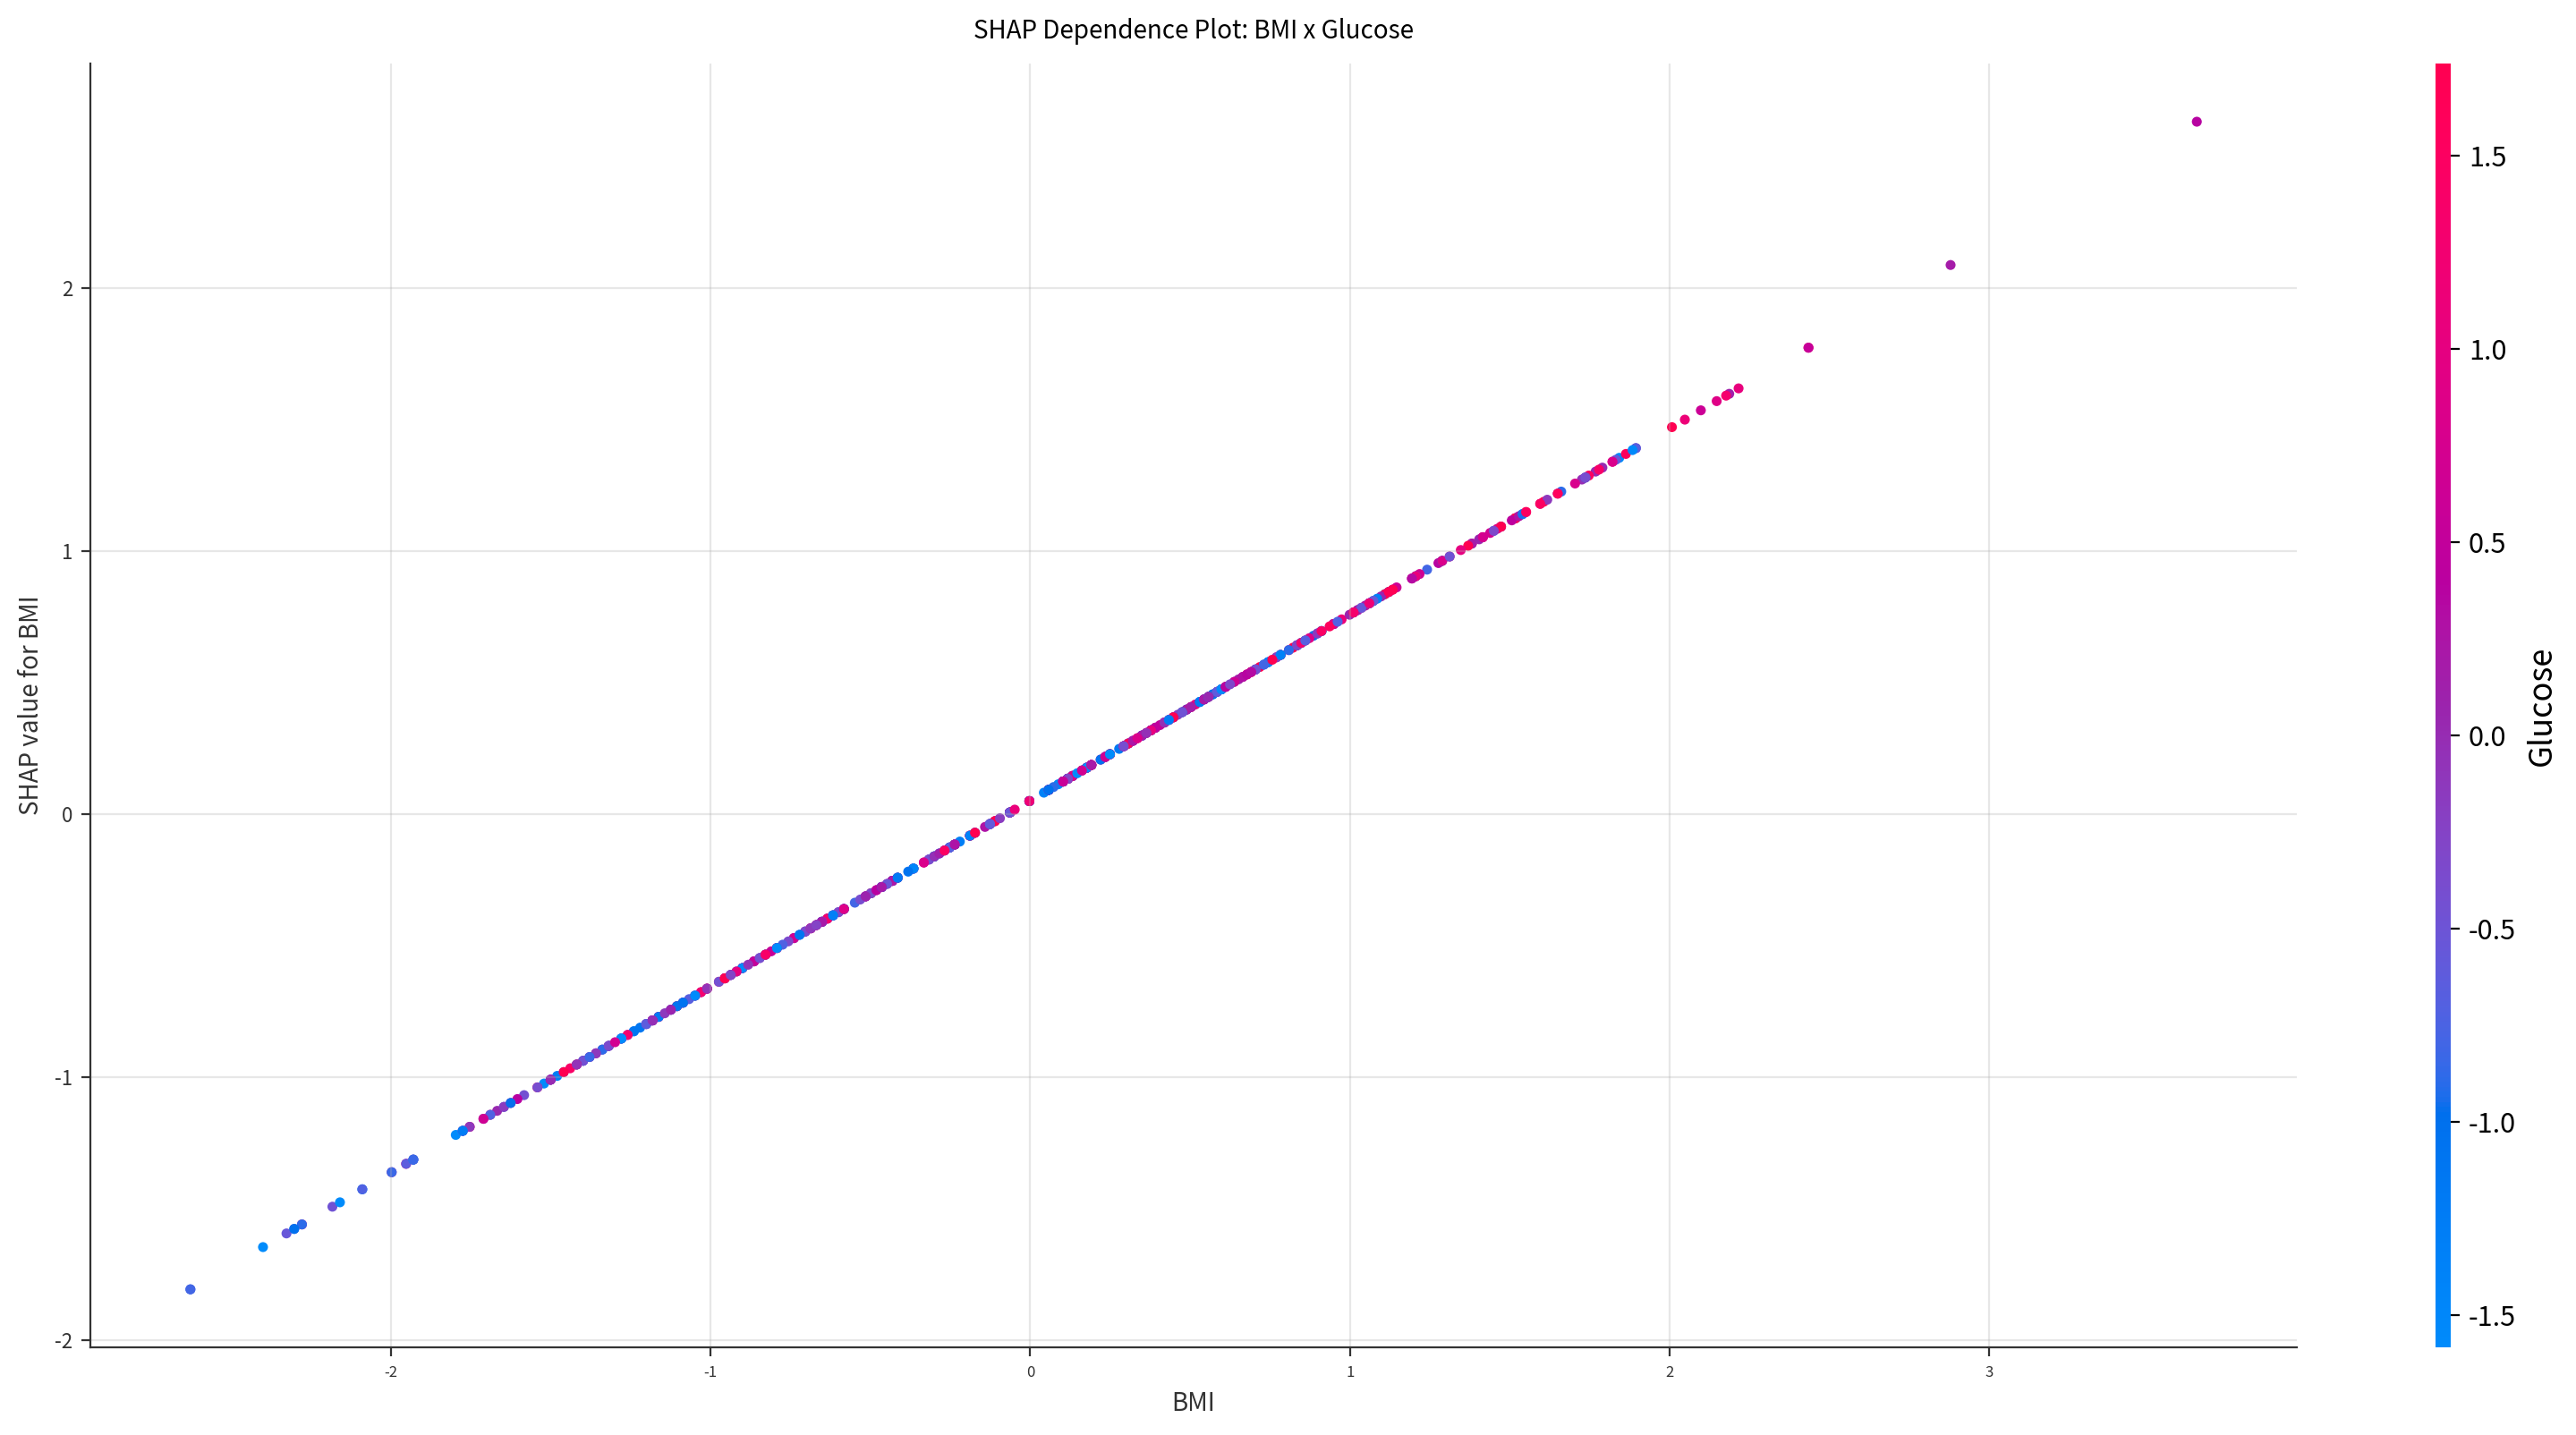

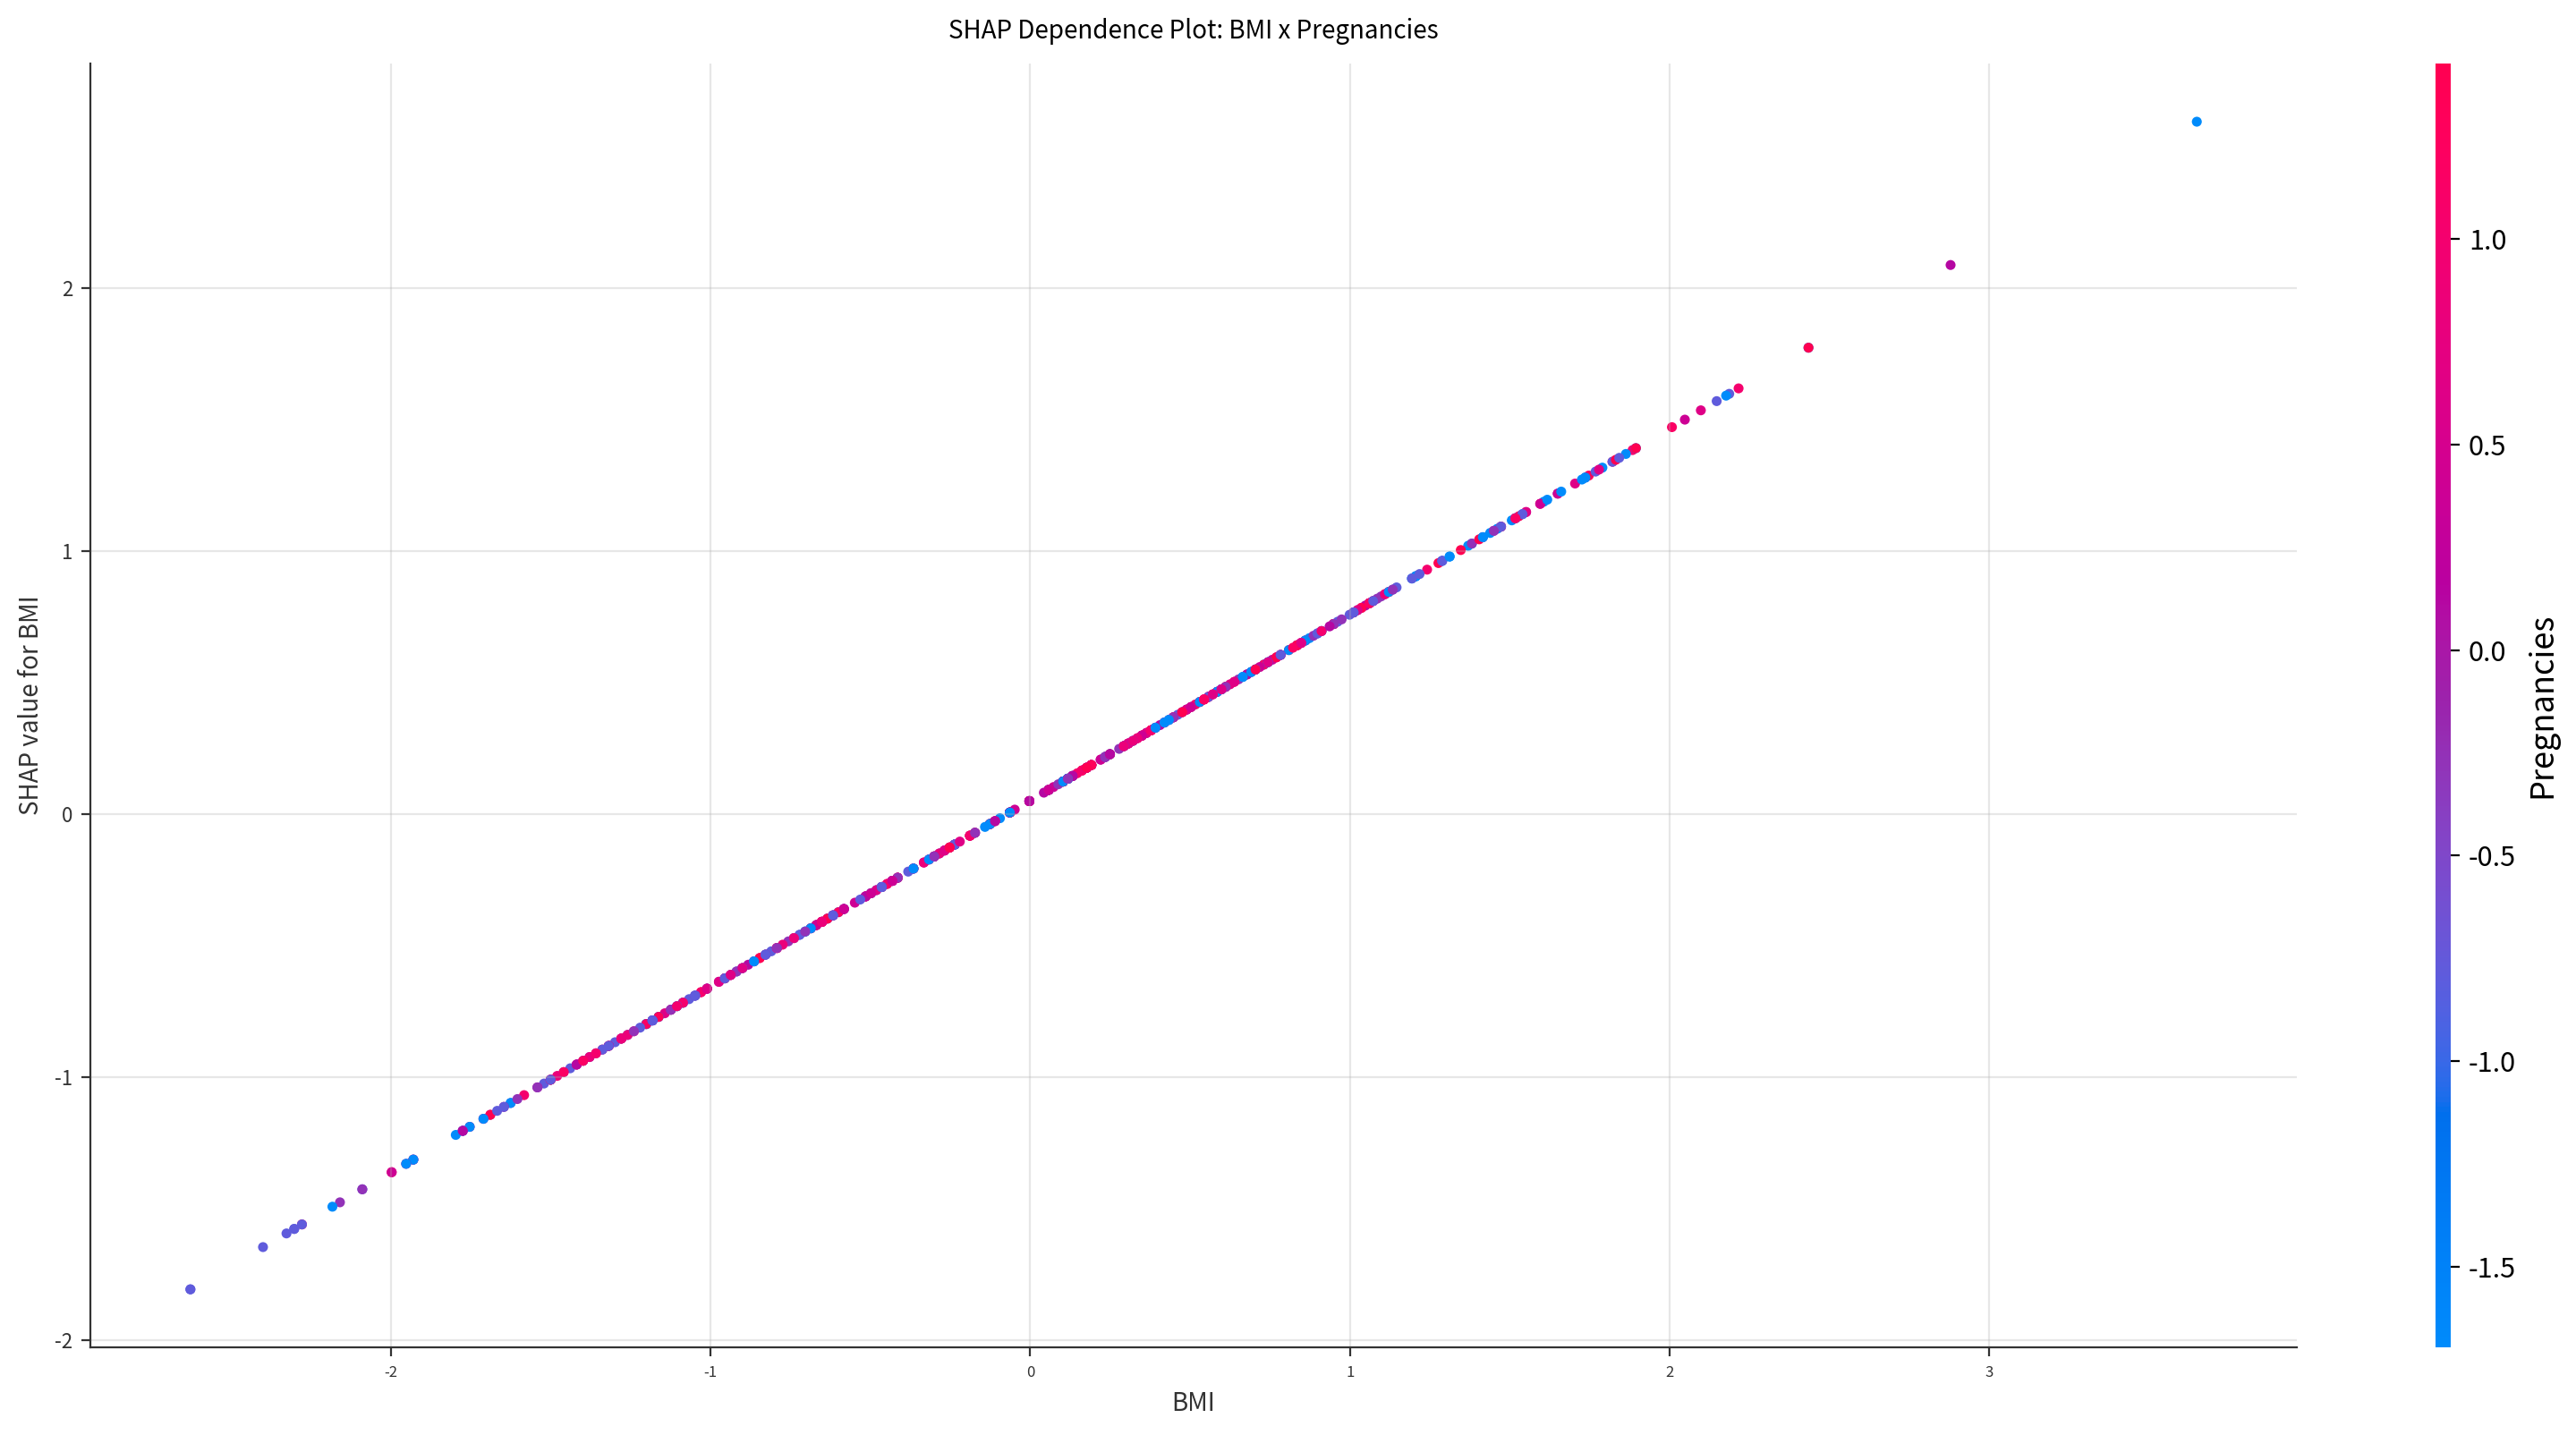

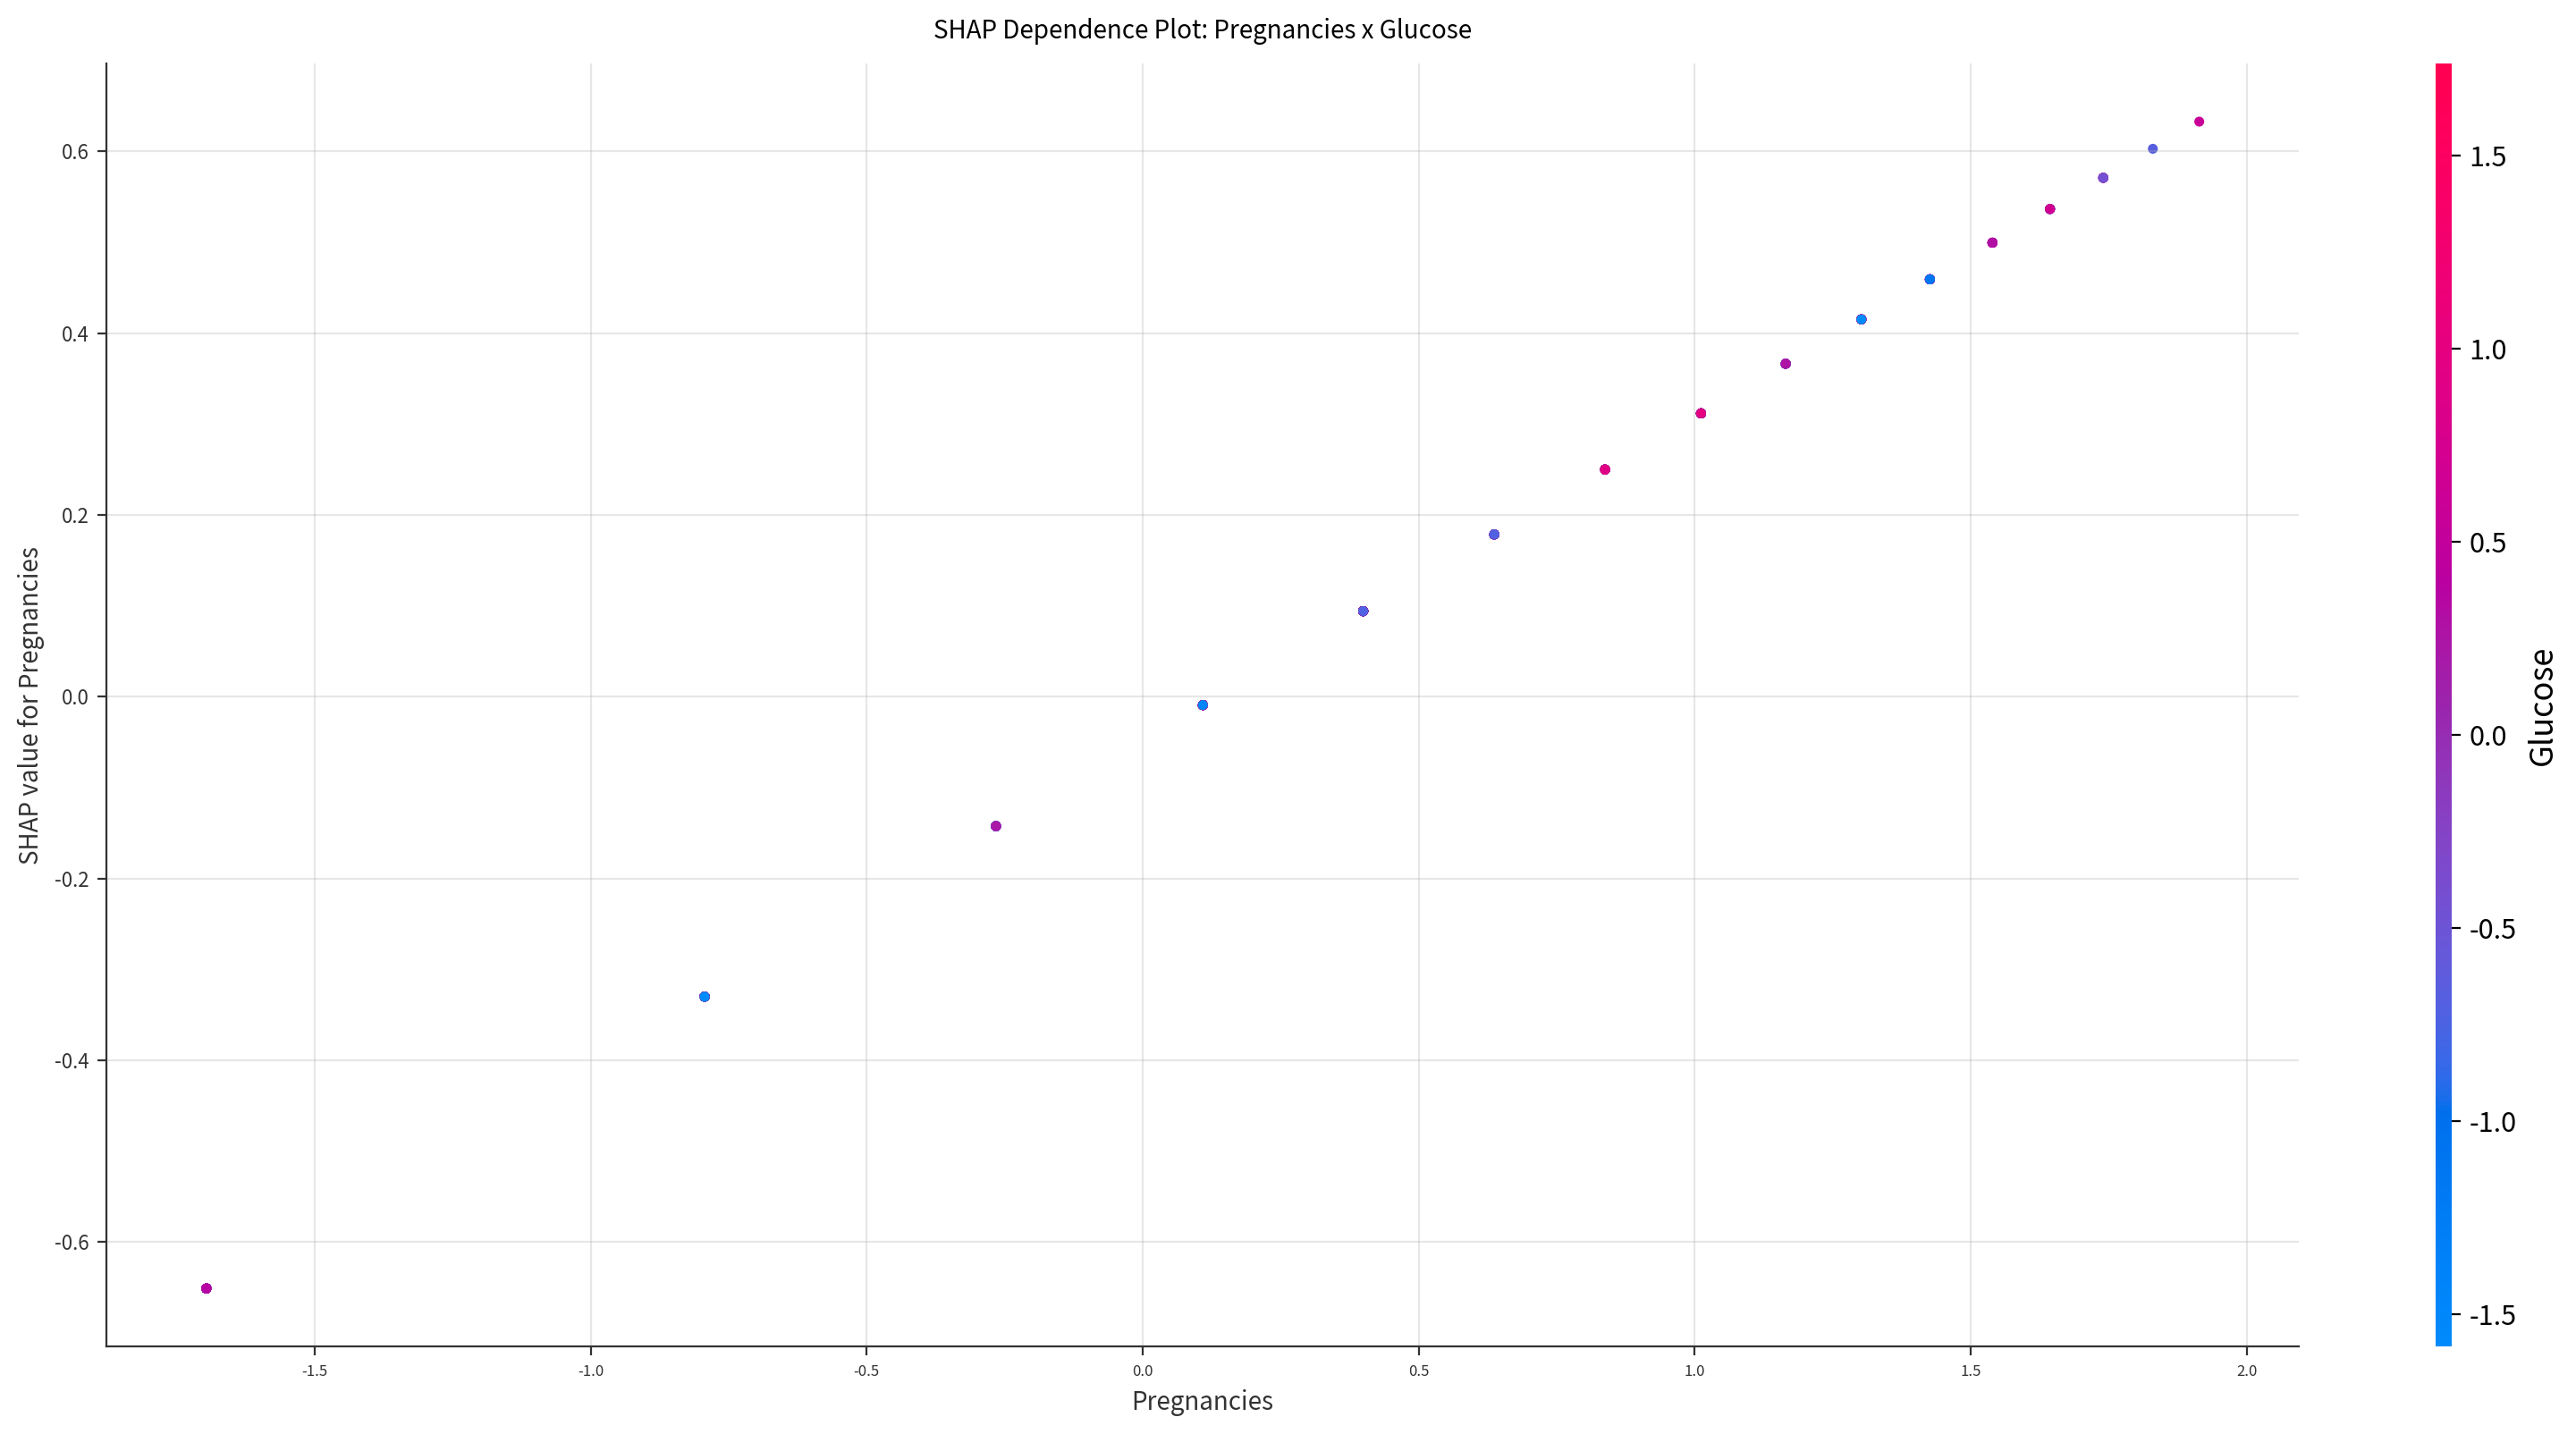

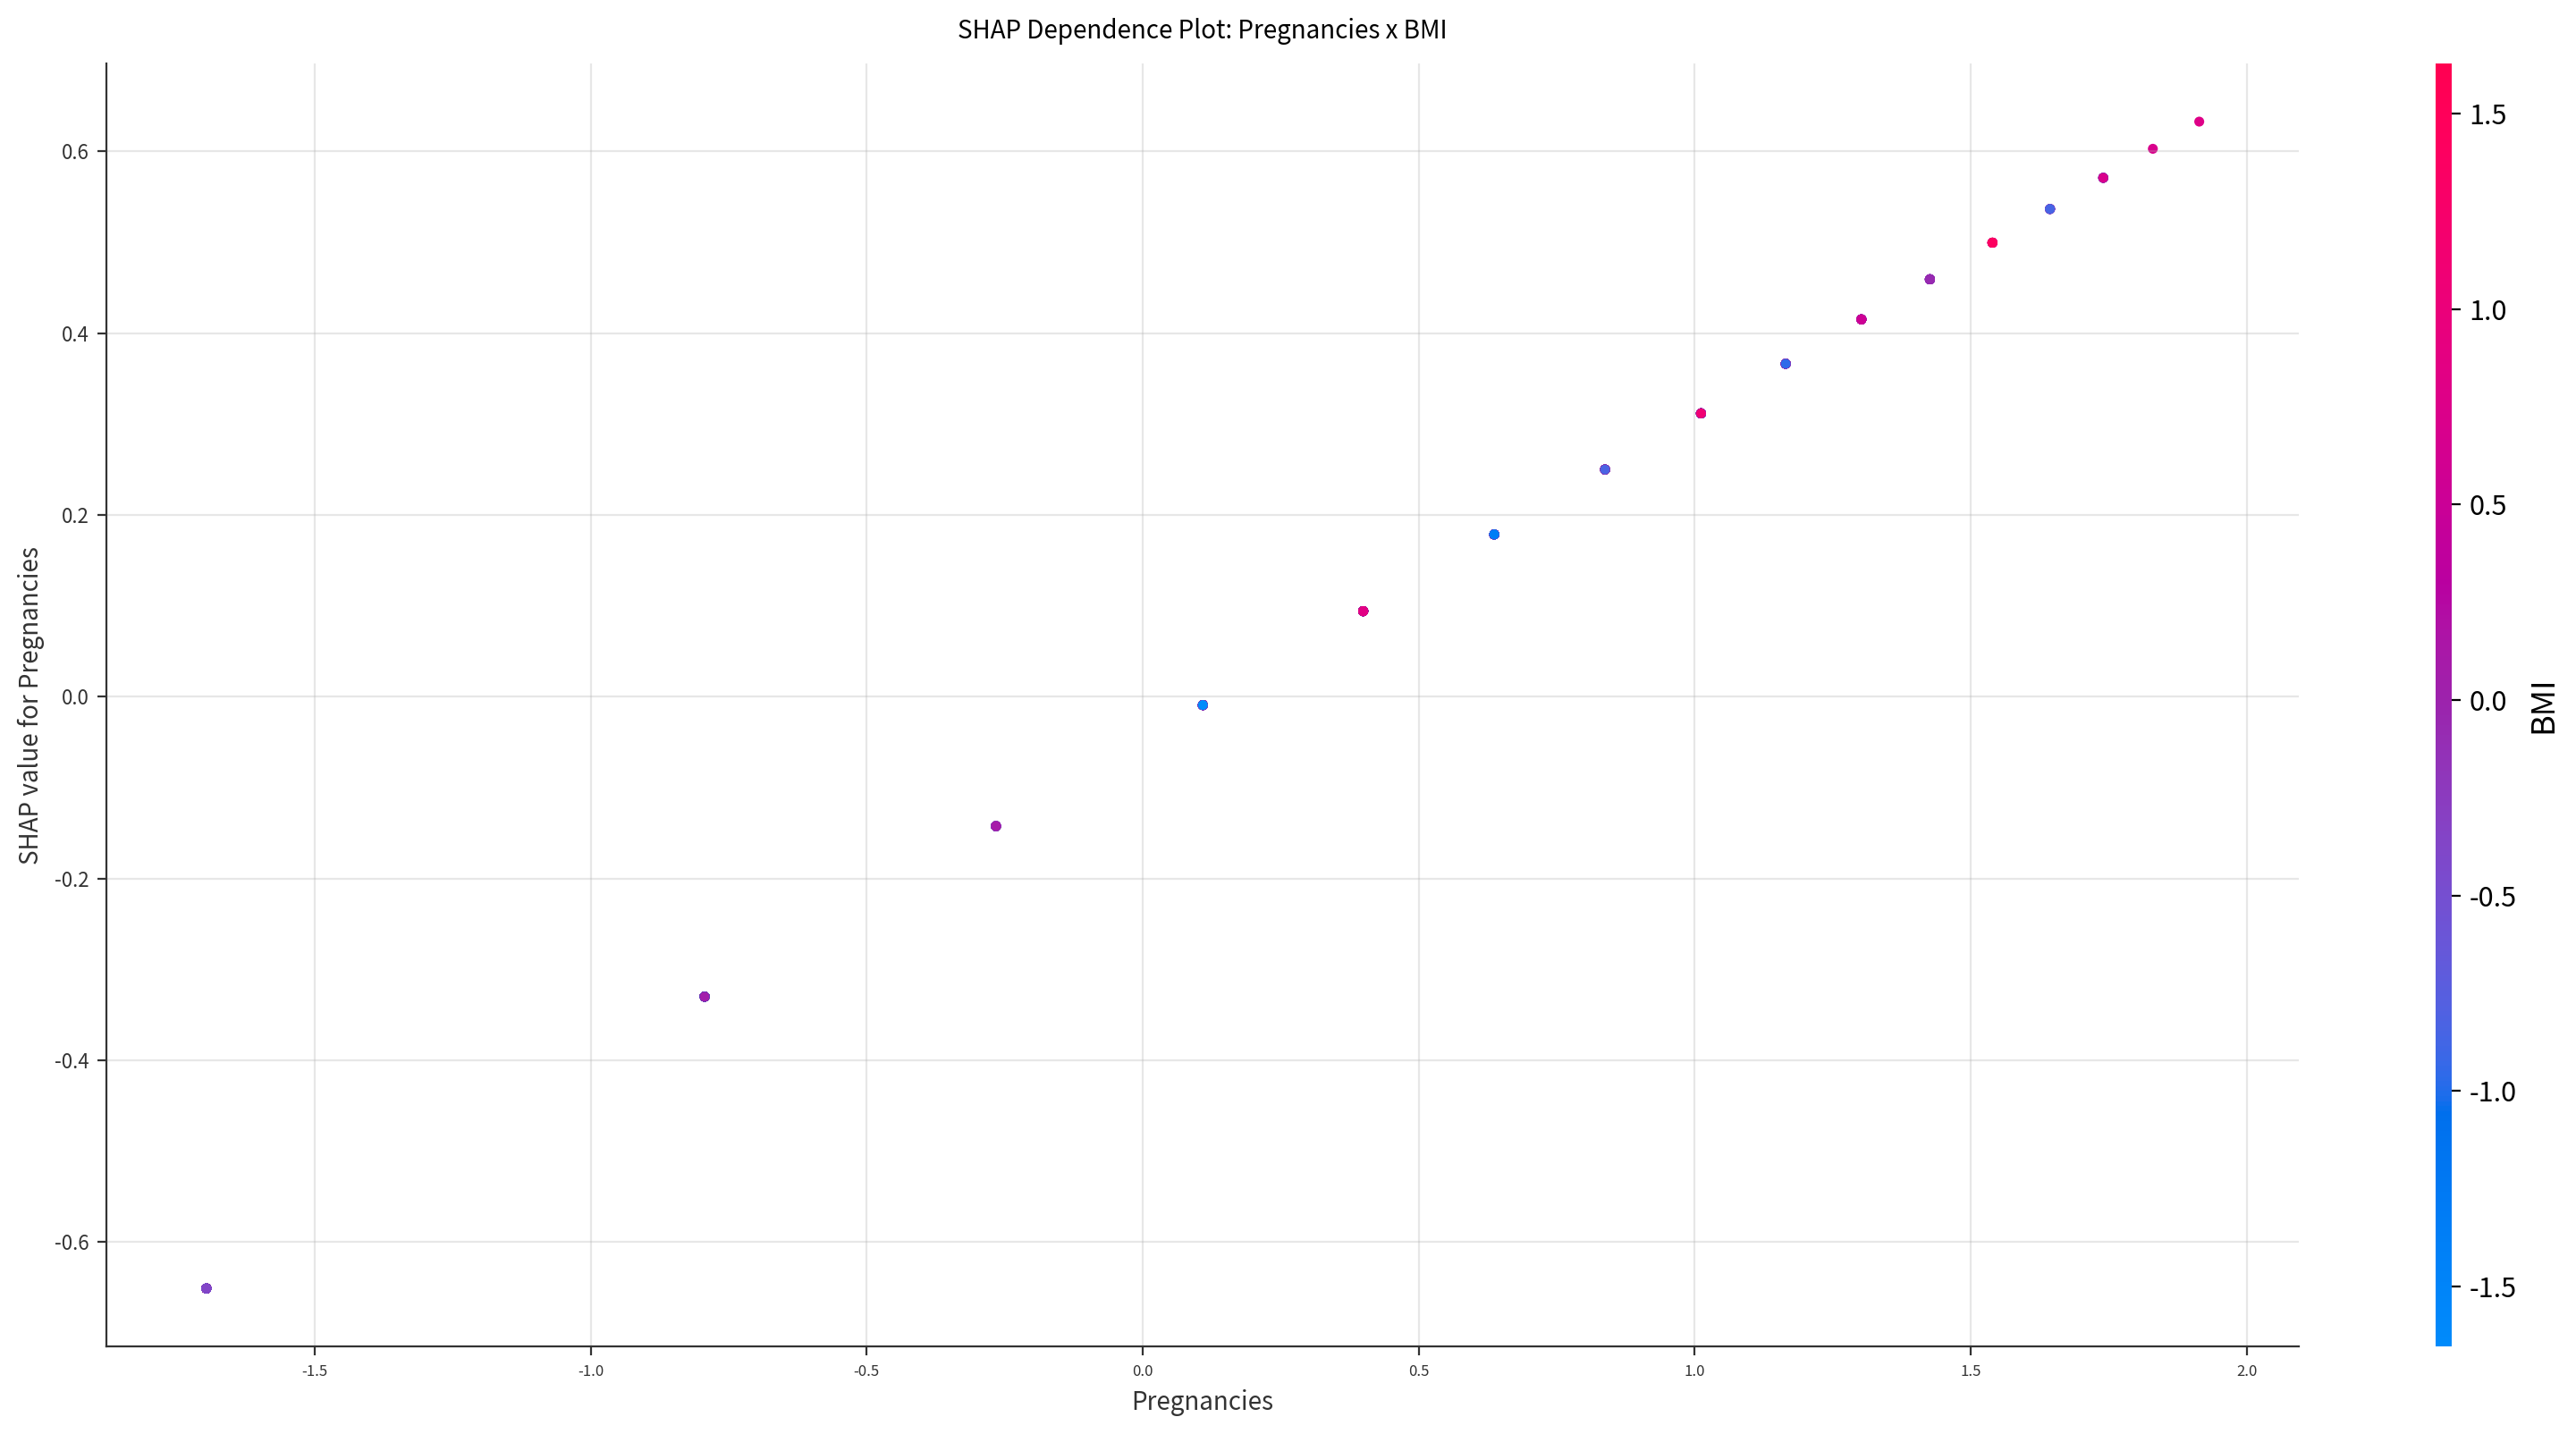

[('Glucose', 'BMI'),
 ('Glucose', 'Pregnancies'),
 ('BMI', 'Glucose'),
 ('BMI', 'Pregnancies'),
 ('Pregnancies', 'Glucose'),
 ('Pregnancies', 'BMI')]

In [10]:
hs_shap_dependence_analysis(summary_df, shap_values, DataFrame(x_scaled, columns=x.columns))